<a target="_blank" href="https://colab.research.google.com/github/heechul/EmbeddedML/blob/main/l5-vww/train-person.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a>

# Person-Detection using Transfer Learning
In this assignment we will use transfer learning to detect if there is a human in a given image. We will use a pre-trained model (MobileNet-V2), which was trained on ImageNet dataset and use a [Kaggle human detection dataset](https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset).

**Acknowledgements**

This colab is heavily borrowed from the [Google's Transfer learning](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/transfer_learning.ipynb) Colab and [EdX TinyML course's](https://github.com/tinyMLx) Mask Detection Colab.


In [30]:
!pip install -U tf_keras  &> 0 # Keras 2
!pip install kagglehub

import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [31]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory


# Suppress only PNG warnings
tf.get_logger().setLevel('ERROR')

RunningInCOLAB = 'google.colab' in str(get_ipython())

## Build the dataset

### Download the dataset

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("constantinwerner/human-detection-dataset")
print("Path to dataset files:", path)

100%|██████████| 260M/260M [00:08<00:00, 33.8MB/s] 

Extracting files...


Path to dataset files: /Users/h488y928/.cache/kagglehub/datasets/constantinwerner/human-detection-dataset/versions/5


In [33]:
if RunningInCOLAB:
    !mv {path} /content/data
    !ls /content/data
    path = "/content/data"
else:
    !mv {path} data
    !ls data
    path = "./data"    
dataset_path = os.path.join(path, "human detection dataset")
print ("Path to dataset files:", dataset_path)

human detection dataset
Path to dataset files: ./data/human detection dataset


In [34]:
topdir = os.getcwd()
if not os.stat('model'):
    os.mkdir('model')
if not os.stat('src'):
    os.mkdir('src')
print(topdir)

/Users/h488y928/Teaching/EmbeddedML/l5-vww


In [35]:
import os
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_SIZE = (96, 96)
dataset = image_dataset_from_directory(dataset_path,
                                        labels='inferred',
                                        label_mode='binary',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

dataset_size = len(list(dataset))  # Get the total number of elements in the dataset
train_size = int(0.8 * dataset_size) # Calculate the size of the training set (80%)
val_size = int(0.2 * dataset_size) # Calculate the size of the validation set (20%)

# Split the dataset into training and validation sets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)

Found 921 files belonging to 2 classes.


2024-11-11 17:41:55.108009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.117105: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.244400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.249005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.266919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.348412: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.505810: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.669679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:55.682150: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Now that we have built the dataset lets view the first nine images and labels from the training set:

2024-11-11 17:41:57.679188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:57.684114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:57.795839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:57.800941: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


['0', '1']


2024-11-11 17:41:57.813774: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:57.881692: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.020560: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.144788: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.153461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.157950: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.347334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:58.408339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


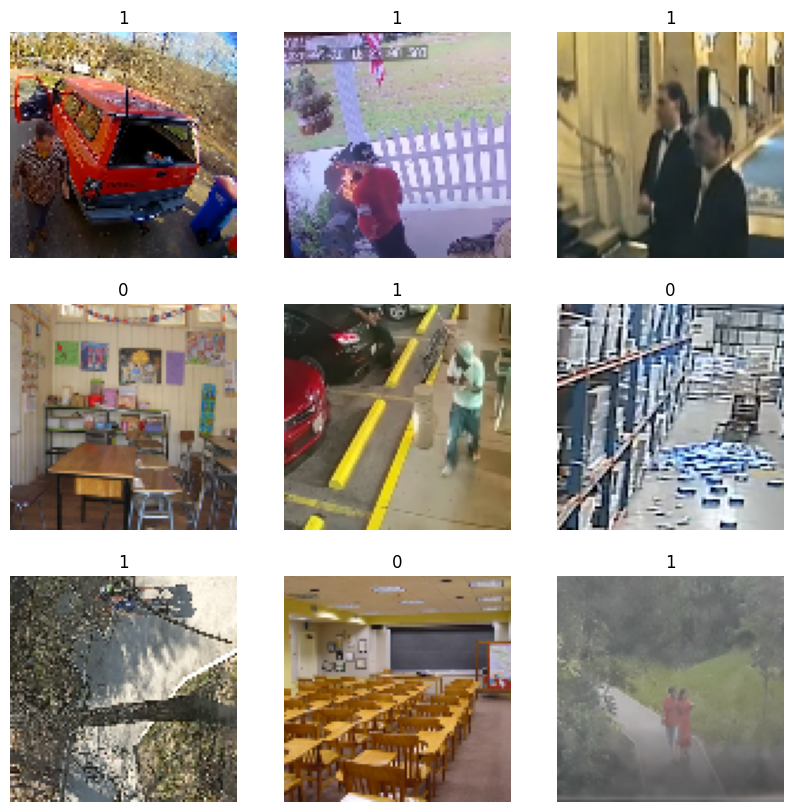

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

class_names = dataset.class_names
print (class_names)
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    idx = labels[i].numpy().astype("uint8")[0]
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[idx])
    plt.axis("off")

### Rescale pixel values

In a moment, you will download `tf.keras.applications.MobileNetV2` for use as your base model. This model expects pixel vaues in `[-1,1]`, but at this point, the pixel values in your images are in `[0-255]`. To rescale them, use the preprocessing method included with the model.

In [37]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

Note: Alternatively, you could rescale pixel values from `[0,255]` to `[-1, 1]` using a [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) layer.

Note: If you go on to use other `tf.keras.applications`, be sure to check the API doc to determine if they expect pixels in `[-1,1]` or `[0,1]`, or use the included `preprocess_input` function.

## Build the Model

### Create the base model
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories including objects such as `jackfruit` and `syringe`. This base of knowledge will help us classify if a person is wearing a mask or not from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will leverage as the high level features you wish to re-use. Since we want to adapt the classifications coming out of the model to a new task, we want to leverage the features coming out of the *last* layer BEFORE the classification layers. In many image models this is the output of the final convolution BEFORE the flatten layer. You may see this layer referred to as the "bottleneck layer" in some texts. Since many machine learning models are defined as the inputs occuring at the bottom and the outputs occuring at the top we would like to ignore the top few classification layers. Fortuntately, there is a shortcut to doing this in TensorFlow, **```include_top=False```**. By passing in this parameter we instantiate a MobileNet V1 model pre-loaded with weights trained on ImageNet that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [38]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               alpha=0.35,
                                               weights='imagenet')

In [39]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-11-11 17:41:59.499653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.502919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.609371: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.612702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.623657: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.689257: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.819317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.939778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:41:59.946125: W tensorflow/core/lib/png/png_io.cc:89] PNG 

(32, 3, 3, 1280)


2024-11-11 17:42:00.138525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


### Freeze the convolutional layers

It is important to freeze the convolutional layers before you compile and train the model with transfer learning. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. We want to perform this operation because we want to leverage the pre-trained values in the convolutional layers and only learn new classification layer values. We can do this by setting the entire model's `trainable` flag to False.

In [40]:
print (base_model.trainable)
base_model.trainable = False
print (base_model.trainable)


True
False


In [41]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_0.35_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 16)           432       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 16)           64        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 48, 48, 16)           0         ['bn_Conv1[0

### Add a classification head

To begin the process of generating classifications from the pretrained features, we use a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the 3x3 spatial features into a single 1024-element feature vector per image.

In [42]:
classification_input_layer = tf.keras.layers.Flatten()
# classification_input_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = classification_input_layer(feature_batch)
print(feature_batch_average.shape)

(32, 11520)


We then apply a `tf.keras.layers.Dense` layer to convert the feature vector into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [43]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


We can then build our final model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). Importantly we remind Tensorflow that we do not want to train the base_model!

In [44]:
inputs = tf.keras.Input(shape=(96, 96, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = classification_input_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with `from_logits=True` since the model provides a linear output. You can see below how we have included the Mobilenet V1 model after the input layer and before our classification layers!

In [45]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 96, 96, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_0.35_96 (Funct  (None, 3, 3, 1280)        410208    
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 11520)             0         
                                                           

## Your Turn: Train and Evaluate the model

Now that we have our model we can train it! You will see that since we are leveraging all of the pre-trained features we can improve our model from a random initialization (accuracy of ~50%) to a model with over 95% accuracy quite quickly. **How many epochs do you think we'll need?**

### Train the model
First print the initial accuracy

In [47]:
loss, accuracy = model.evaluate(val_dataset)
print('Test accuracy :', accuracy)

2024-11-11 17:42:01.638789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:01.643018: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:01.793149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:01.794322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:01.819049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:01.903651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:02.047036: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:02.166319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:02.174039: W tensorflow/core/lib/png/png_io.cc:89] PNG 

5/5 [==============================] - 3s 26ms/step - loss: 0.8127 - accuracy: 0.6062
Test accuracy : 0.606249988079071


2024-11-11 17:42:03.942357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


**Now its your turn to pick the number of epochs of training! Remmeber we are aiming for at least 95% accuracy on the test set!**

*Hint: Despite the fact that it would take more than a day to train this model from scratch, it requires far fewer epochs to train it with transfer learning than you might suspect! You probably have more fingers and toes than the number of epochs you will need!*

In [48]:
EPOCHS = 20  
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=val_dataset,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


Epoch 1/20


2024-11-11 17:42:05.819607: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:05.823104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:05.929918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:05.930673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:05.945149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.011028: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.144057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.271343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.278937: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 1.0979 - accuracy: 0.4531 

2024-11-11 17:42:06.475016: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.541828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.9212 - accuracy: 0.5273

2024-11-11 17:42:06.859553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.913566: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:06.987487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.9084 - accuracy: 0.5286

2024-11-11 17:42:07.185006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.382840: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.385945: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.8780 - accuracy: 0.5488

2024-11-11 17:42:07.469654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.509904: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.558229: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.618400: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.8426 - accuracy: 0.5719

2024-11-11 17:42:07.888942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:07.947525: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.031475: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.8258 - accuracy: 0.5788

2024-11-11 17:42:08.140968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.235000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.238867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.349445: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.351523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.366488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.434024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.591158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:08.754354: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 7s 186ms/step - loss: 0.8258 - accuracy: 0.5788 - val_loss: 0.6258 - val_accuracy: 0.6812
Epoch 2/20


2024-11-11 17:42:10.499567: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.653436: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.659903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.769752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.771611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.785987: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.852724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:10.993220: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:11.125191: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.6016 - accuracy: 0.7188 

2024-11-11 17:42:11.337158: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:11.408262: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.5922 - accuracy: 0.7109

2024-11-11 17:42:11.716109: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:11.766694: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:11.841465: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/23 [=============>................] - ETA: 0s - loss: 0.5778 - accuracy: 0.7159

2024-11-11 17:42:12.032260: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.5836 - accuracy: 0.7232

2024-11-11 17:42:12.269540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.273038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.364490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.417741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.444033: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.5887 - accuracy: 0.7279

2024-11-11 17:42:12.512882: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.6063 - accuracy: 0.7172

2024-11-11 17:42:12.781615: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.838112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:12.853388: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.7283

2024-11-11 17:42:12.990272: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.095029: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.099100: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.219661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.219848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.236262: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.302819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.443413: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:13.582407: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 194ms/step - loss: 0.5952 - accuracy: 0.7283 - val_loss: 0.4445 - val_accuracy: 0.7875
Epoch 3/20


2024-11-11 17:42:15.540626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.709300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.715613: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.833963: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.835382: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.850307: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:15.924439: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:16.073944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:16.205966: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.4079 - accuracy: 0.8594 

2024-11-11 17:42:16.436873: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:16.514590: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.4733 - accuracy: 0.7930

2024-11-11 17:42:16.873587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:16.932053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:17.008990: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.4893 - accuracy: 0.7786

2024-11-11 17:42:17.286504: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.4731 - accuracy: 0.7835

2024-11-11 17:42:17.518819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:17.527896: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:17.616903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:17.675458: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:17.709738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.4765 - accuracy: 0.7831

2024-11-11 17:42:17.773482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.4679 - accuracy: 0.7922

2024-11-11 17:42:18.065004: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.125938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.222194: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.4776 - accuracy: 0.7857

2024-11-11 17:42:18.333614: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.432994: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.437808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.548167: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.549771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.565724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.632281: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.803317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:18.969772: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 200ms/step - loss: 0.4809 - accuracy: 0.7812 - val_loss: 0.4015 - val_accuracy: 0.8250
Epoch 4/20


2024-11-11 17:42:20.733097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:20.939559: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:20.943757: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.065441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.070618: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.083879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.156947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.298245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.424645: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.4060 - accuracy: 0.8281 

2024-11-11 17:42:21.645096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:21.714312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.4148 - accuracy: 0.7930

2024-11-11 17:42:22.049441: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.101252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.168836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.4049 - accuracy: 0.7969

2024-11-11 17:42:22.358743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.3966 - accuracy: 0.8080

2024-11-11 17:42:22.581721: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.584842: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.672992: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.723725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:22.749793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.3933 - accuracy: 0.8199

2024-11-11 17:42:22.811303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.3958 - accuracy: 0.8172

2024-11-11 17:42:23.084580: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.145575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.220579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.3903 - accuracy: 0.8185

2024-11-11 17:42:23.329743: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.415090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.417928: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.526464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.530093: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.542052: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.608323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.744188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:23.871373: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 185ms/step - loss: 0.3894 - accuracy: 0.8193 - val_loss: 0.3174 - val_accuracy: 0.8875
Epoch 5/20


2024-11-11 17:42:25.646087: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:25.801835: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:25.805740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:25.922155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:25.923241: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:25.939640: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:26.007899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:26.140500: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:26.262738: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.3019 - accuracy: 0.8594 

2024-11-11 17:42:26.465297: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:26.538554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.3351 - accuracy: 0.8555

2024-11-11 17:42:26.876370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:26.932524: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.009702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.3589 - accuracy: 0.8594

2024-11-11 17:42:27.216259: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.410540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.415113: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.3504 - accuracy: 0.8633

2024-11-11 17:42:27.495978: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.536481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.567488: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.634813: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.3456 - accuracy: 0.8625

2024-11-11 17:42:27.892918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:27.949689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.021786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.3512 - accuracy: 0.8533

2024-11-11 17:42:28.129343: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.222079: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.225269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.330553: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.334877: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.347311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.410152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.541544: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:28.666005: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 180ms/step - loss: 0.3512 - accuracy: 0.8533 - val_loss: 0.3227 - val_accuracy: 0.8750
Epoch 6/20


2024-11-11 17:42:30.374647: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.508188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.512514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.617861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.619296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.633376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.697755: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:30.837920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:31.007282: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.3646 - accuracy: 0.8125 

2024-11-11 17:42:31.215219: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:31.282180: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.3463 - accuracy: 0.8438

2024-11-11 17:42:31.592405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:31.646809: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:31.715225: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.3621 - accuracy: 0.8385

2024-11-11 17:42:31.914775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.3445 - accuracy: 0.8482

2024-11-11 17:42:32.118751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.123276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.211503: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.251942: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.283246: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.3344 - accuracy: 0.8566

2024-11-11 17:42:32.344336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.3312 - accuracy: 0.8594

2024-11-11 17:42:32.629761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.686921: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:32.766454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.3317 - accuracy: 0.8573

2024-11-11 17:42:32.923663: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.023685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.027793: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.137480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.141841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.153829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.221918: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.363406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:33.497039: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 186ms/step - loss: 0.3317 - accuracy: 0.8573 - val_loss: 0.3059 - val_accuracy: 0.8687
Epoch 7/20


2024-11-11 17:42:35.248353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.397318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.400547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.507919: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.510353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.527615: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.592210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.728974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:35.849087: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.3128 - accuracy: 0.8281 

2024-11-11 17:42:36.049450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:36.111182: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.3053 - accuracy: 0.8633

2024-11-11 17:42:36.438404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:36.491558: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:36.564319: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.2925 - accuracy: 0.8672

2024-11-11 17:42:36.762982: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:36.952112: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:36.955993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


15/23 [==================>...........] - ETA: 0s - loss: 0.2903 - accuracy: 0.8583

2024-11-11 17:42:37.040489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.081964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.113487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.229089: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2823 - accuracy: 0.8656

2024-11-11 17:42:37.500574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.557057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.632955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.2796 - accuracy: 0.8676

2024-11-11 17:42:37.741063: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.830231: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.833119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.945732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.946427: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:37.962118: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:38.026077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:38.157518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:38.274558: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 183ms/step - loss: 0.2764 - accuracy: 0.8709 - val_loss: 0.2623 - val_accuracy: 0.9250
Epoch 8/20


2024-11-11 17:42:40.010372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.167511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.171924: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.278763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.279111: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.297242: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.363099: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.496720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.627941: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.2830 - accuracy: 0.8906 

2024-11-11 17:42:40.834348: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:40.899750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.2452 - accuracy: 0.9141

2024-11-11 17:42:41.250302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:41.333881: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:41.415250: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.2672 - accuracy: 0.8932

2024-11-11 17:42:41.633341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.2651 - accuracy: 0.8906

2024-11-11 17:42:41.838637: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:41.841138: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:41.938188: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:41.989824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.027539: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.2598 - accuracy: 0.8952

2024-11-11 17:42:42.139761: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2605 - accuracy: 0.8969

2024-11-11 17:42:42.419195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.477642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.551878: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.2607 - accuracy: 0.8940

2024-11-11 17:42:42.663056: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.766799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.770491: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.882853: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.895358: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.907636: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:42.973502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:43.102786: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:43.231792: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 190ms/step - loss: 0.2607 - accuracy: 0.8940 - val_loss: 0.2528 - val_accuracy: 0.9062
Epoch 9/20


2024-11-11 17:42:44.970312: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.113091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.120868: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.229341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.229406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.247103: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.312098: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.449318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.569862: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.2820 - accuracy: 0.8594 

2024-11-11 17:42:45.777317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:45.846232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.2378 - accuracy: 0.9023

2024-11-11 17:42:46.177957: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.236184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.307804: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.2289 - accuracy: 0.9167

2024-11-11 17:42:46.521933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.710541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.713354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.2411 - accuracy: 0.9082

2024-11-11 17:42:46.838536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.881630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.922474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:46.987867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2412 - accuracy: 0.9094

2024-11-11 17:42:47.256016: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.312933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.388406: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9103

2024-11-11 17:42:47.497214: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.596583: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.601335: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.708208: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.711064: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.728760: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.794337: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:47.927275: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:48.055642: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 186ms/step - loss: 0.2419 - accuracy: 0.9103 - val_loss: 0.2332 - val_accuracy: 0.9187
Epoch 10/20


2024-11-11 17:42:49.808417: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:49.956829: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:49.961283: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.071447: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.075619: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.089153: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.157318: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.289007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.410342: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.2170 - accuracy: 0.9219 

2024-11-11 17:42:50.606480: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:50.666700: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.2063 - accuracy: 0.9180

2024-11-11 17:42:51.006983: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.063836: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.139461: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1969 - accuracy: 0.9193

2024-11-11 17:42:51.336827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.529808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.533301: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.2263 - accuracy: 0.9141

2024-11-11 17:42:51.619574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.661494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.692494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:51.750609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2214 - accuracy: 0.9219

2024-11-11 17:42:52.016144: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.088789: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.164076: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.2159 - accuracy: 0.9226

2024-11-11 17:42:52.275973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.373462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.377187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.500134: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.500226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.517980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.582854: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.715000: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:52.840014: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 184ms/step - loss: 0.2159 - accuracy: 0.9226 - val_loss: 0.2325 - val_accuracy: 0.9312
Epoch 11/20


2024-11-11 17:42:54.586195: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.733980: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.740933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.849320: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.855597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.866783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:54.933598: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:55.069828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:55.225795: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.2112 - accuracy: 0.9062 

2024-11-11 17:42:55.429976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:55.494933: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1783 - accuracy: 0.9453

2024-11-11 17:42:55.824129: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:55.885393: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:55.957673: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1953 - accuracy: 0.9375

2024-11-11 17:42:56.170770: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.370867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.373101: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1994 - accuracy: 0.9297

2024-11-11 17:42:56.462586: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.508592: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.538442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.599506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2017 - accuracy: 0.9281

2024-11-11 17:42:56.869797: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:56.926953: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.002929: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.2024 - accuracy: 0.9286

2024-11-11 17:42:57.109578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.199955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.203584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.313298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.313404: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.361630: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.434753: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.571482: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:57.702300: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 184ms/step - loss: 0.2114 - accuracy: 0.9226 - val_loss: 0.2721 - val_accuracy: 0.9062
Epoch 12/20


2024-11-11 17:42:59.442719: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.576803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.581080: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.693193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.700597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.713146: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.779483: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:42:59.912923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:00.043380: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1999 - accuracy: 0.9219 

2024-11-11 17:43:00.247027: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:00.311496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.1924 - accuracy: 0.9297

2024-11-11 17:43:00.629013: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:00.674679: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:00.747366: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1906 - accuracy: 0.9323

2024-11-11 17:43:00.985450: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1994 - accuracy: 0.9263

2024-11-11 17:43:01.188152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.191428: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.279568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.331322: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.364908: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.2030 - accuracy: 0.9246

2024-11-11 17:43:01.444898: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.2036 - accuracy: 0.9250

2024-11-11 17:43:01.713324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.773826: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:01.850938: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9212

2024-11-11 17:43:01.960512: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.074795: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.077279: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.181746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.186899: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.199205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.268025: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.402858: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:02.527913: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 181ms/step - loss: 0.2100 - accuracy: 0.9212 - val_loss: 0.2003 - val_accuracy: 0.9563
Epoch 13/20


2024-11-11 17:43:04.177418: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.318872: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.325017: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.433487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.438483: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.451132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.516352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.653506: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:04.775362: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1718 - accuracy: 0.9688 

2024-11-11 17:43:04.986518: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:05.053653: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1684 - accuracy: 0.9570

2024-11-11 17:43:05.404811: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:05.459925: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:05.527890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/23 [=============>................] - ETA: 0s - loss: 0.1754 - accuracy: 0.9517

2024-11-11 17:43:05.732349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1785 - accuracy: 0.9397

2024-11-11 17:43:05.980812: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:05.983264: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.067554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.105956: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.136807: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.1747 - accuracy: 0.9412

2024-11-11 17:43:06.211151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1806 - accuracy: 0.9406

2024-11-11 17:43:06.472024: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.528623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.604119: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1804 - accuracy: 0.9402

2024-11-11 17:43:06.710656: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.807349: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.811845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.917575: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.920886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:06.936309: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:07.002787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:07.144095: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:07.281078: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 187ms/step - loss: 0.1804 - accuracy: 0.9402 - val_loss: 0.1617 - val_accuracy: 0.9563
Epoch 14/20


2024-11-11 17:43:09.042880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.200631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.204107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.313800: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.316057: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.330784: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.394666: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.525359: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.652952: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1728 - accuracy: 0.9375 

2024-11-11 17:43:09.857725: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:09.922425: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1702 - accuracy: 0.9258

2024-11-11 17:43:10.260502: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.318960: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.390091: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1626 - accuracy: 0.9323

2024-11-11 17:43:10.588578: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.778864: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.783686: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1700 - accuracy: 0.9375

2024-11-11 17:43:10.868474: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.904145: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.928498: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:10.991999: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1686 - accuracy: 0.9422

2024-11-11 17:43:11.260675: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.317808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.391476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


22/23 [===========================>..] - ETA: 0s - loss: 0.1744 - accuracy: 0.9375

2024-11-11 17:43:11.495848: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.625647: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.628626: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.735173: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.740038: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.751389: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.817609: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:11.943593: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:12.071984: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 181ms/step - loss: 0.1741 - accuracy: 0.9375 - val_loss: 0.1863 - val_accuracy: 0.9438
Epoch 15/20


2024-11-11 17:43:13.784096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:13.926996: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:13.930850: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.043161: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.044795: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.059471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.123949: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.253886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.375375: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1684 - accuracy: 0.9219 

2024-11-11 17:43:14.579550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:14.641206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.1580 - accuracy: 0.9492

2024-11-11 17:43:14.955547: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.009920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.081022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1522 - accuracy: 0.9531

2024-11-11 17:43:15.289137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.484054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.488287: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1547 - accuracy: 0.9531

2024-11-11 17:43:15.612642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.648765: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.676748: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:15.738387: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1576 - accuracy: 0.9500

2024-11-11 17:43:16.018752: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.079170: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.158223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9524

2024-11-11 17:43:16.268508: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.373271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.377851: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.487523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.491296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.504772: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.575151: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.707662: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:16.828416: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 184ms/step - loss: 0.1548 - accuracy: 0.9524 - val_loss: 0.1481 - val_accuracy: 0.9563
Epoch 16/20


2024-11-11 17:43:18.572254: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.725066: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.729116: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.838975: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.842169: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.855573: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:18.922444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:19.093828: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:19.221205: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1046 - accuracy: 0.9844 

2024-11-11 17:43:19.429740: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:19.495402: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1415 - accuracy: 0.9531

2024-11-11 17:43:19.823857: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:19.880934: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:19.951993: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1325 - accuracy: 0.9609

2024-11-11 17:43:20.148505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.337841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.342096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1310 - accuracy: 0.9629

2024-11-11 17:43:20.424276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.462920: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.488065: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.555398: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1453 - accuracy: 0.9594

2024-11-11 17:43:20.840528: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.896645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:20.978434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


21/23 [==========================>...] - ETA: 0s - loss: 0.1488 - accuracy: 0.9568

2024-11-11 17:43:21.079434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.168513: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.171944: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.279252: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.279540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.293148: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.356973: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.487947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:21.619030: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 177ms/step - loss: 0.1521 - accuracy: 0.9552 - val_loss: 0.1275 - val_accuracy: 0.9750
Epoch 17/20


2024-11-11 17:43:23.287859: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.427374: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.431352: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.539642: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.552724: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.561574: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.633747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.765067: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:23.893213: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1640 - accuracy: 0.9375 

2024-11-11 17:43:24.097787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:24.201354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1220 - accuracy: 0.9805

2024-11-11 17:43:24.553470: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:24.608104: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:24.679981: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1221 - accuracy: 0.9792

2024-11-11 17:43:24.931132: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.131628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.135298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


16/23 [===================>..........] - ETA: 0s - loss: 0.1236 - accuracy: 0.9727

2024-11-11 17:43:25.223794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.265571: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.292754: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.363936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1340 - accuracy: 0.9641

2024-11-11 17:43:25.638792: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.696856: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.781749: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1320 - accuracy: 0.9674

2024-11-11 17:43:25.890489: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.985779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:25.989405: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.098799: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.101235: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.117198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.184651: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.321685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:26.447561: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 190ms/step - loss: 0.1320 - accuracy: 0.9674 - val_loss: 0.1166 - val_accuracy: 0.9812
Epoch 18/20


2024-11-11 17:43:28.243128: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.406090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.411122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.527720: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.528523: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.543645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.614727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.752597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:28.914574: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1465 - accuracy: 0.9688 

2024-11-11 17:43:29.122723: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:29.200276: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1322 - accuracy: 0.9805

2024-11-11 17:43:29.539317: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:29.597203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:29.670817: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1312 - accuracy: 0.9766

2024-11-11 17:43:29.886086: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1245 - accuracy: 0.9777

2024-11-11 17:43:30.093541: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.097232: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.194030: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.242677: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.271791: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.1237 - accuracy: 0.9779

2024-11-11 17:43:30.361077: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1362 - accuracy: 0.9688

2024-11-11 17:43:30.650964: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.710769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:30.789511: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9688

2024-11-11 17:43:30.898923: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.006228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.009794: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.160505: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.163200: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.177764: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.248353: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.389237: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:31.522364: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 191ms/step - loss: 0.1384 - accuracy: 0.9688 - val_loss: 0.1228 - val_accuracy: 0.9812
Epoch 19/20


2024-11-11 17:43:33.271747: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.412373: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.416442: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.521588: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.526823: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.541471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.605108: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.738193: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:33.858547: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.0972 - accuracy: 1.0000 

2024-11-11 17:43:34.073722: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:34.140538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 1s - loss: 0.1175 - accuracy: 0.9844

2024-11-11 17:43:34.476540: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:34.533659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:34.615650: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


11/23 [=============>................] - ETA: 0s - loss: 0.1104 - accuracy: 0.9830

2024-11-11 17:43:34.818464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1108 - accuracy: 0.9799

2024-11-11 17:43:35.052055: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.054922: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.142437: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.184054: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.208926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.1155 - accuracy: 0.9779

2024-11-11 17:43:35.278422: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1245 - accuracy: 0.9719

2024-11-11 17:43:35.560914: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.621805: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.699037: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1235 - accuracy: 0.9715

2024-11-11 17:43:35.819020: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.913363: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:35.926084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.033271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.037900: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.052130: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.119714: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.265183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:36.386556: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 186ms/step - loss: 0.1235 - accuracy: 0.9715 - val_loss: 0.1229 - val_accuracy: 0.9625
Epoch 20/20


2024-11-11 17:43:38.118469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.268376: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.273007: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.384715: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.385671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.399414: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.465689: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.601729: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.713846: W tensorflow/core/lib/png/png_io.cc:89] PNG 

 2/23 [=>............................] - ETA: 1s - loss: 0.1213 - accuracy: 0.9688 

2024-11-11 17:43:38.910685: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:38.970787: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


 8/23 [=========>....................] - ETA: 0s - loss: 0.1157 - accuracy: 0.9727

2024-11-11 17:43:39.275676: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.330383: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.399947: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


12/23 [==============>...............] - ETA: 0s - loss: 0.1089 - accuracy: 0.9766

2024-11-11 17:43:39.592096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


14/23 [=================>............] - ETA: 0s - loss: 0.1094 - accuracy: 0.9777

2024-11-11 17:43:39.794935: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.797771: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.882341: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.920092: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:39.949841: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


17/23 [=====================>........] - ETA: 0s - loss: 0.1051 - accuracy: 0.9779

2024-11-11 17:43:40.019298: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


20/23 [=========================>....] - ETA: 0s - loss: 0.1123 - accuracy: 0.9719

2024-11-11 17:43:40.278708: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.372310: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.449197: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


23/23 [==============================] - ETA: 0s - loss: 0.1171 - accuracy: 0.9674

2024-11-11 17:43:40.556520: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.648137: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.651796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.766152: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.770584: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.786965: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.854629: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:40.995106: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:41.130067: W tensorflow/core/lib/png/png_io.cc:89] PNG 

23/23 [==============================] - 5s 184ms/step - loss: 0.1171 - accuracy: 0.9674 - val_loss: 0.0945 - val_accuracy: 0.9875


2024-11-11 17:43:42.890334: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


Did you hit you accuracy goal? Did you overshoot and spend some extra time training? When might you have been able to quit? Lets take a look at the learning curves of the training and validation accuracy/loss to analyze our results.

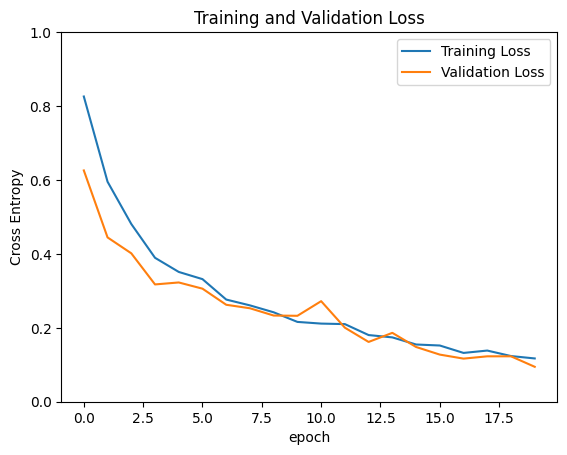

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']
# plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate your model

The last thing we need to do is check if the model is overfitting or if it actually learned the problem that fast! Does you model still perform well on the test set? Lets find out!

In [50]:
loss, accuracy = model.evaluate(val_dataset)
print('Test accuracy :', accuracy)

2024-11-11 17:43:43.207542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.213460: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.328709: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.328976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.342587: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.407366: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.536891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.659802: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:43:43.667957: W tensorflow/core/lib/png/png_io.cc:89] PNG 

5/5 [==============================] - 2s 24ms/step - loss: 0.1184 - accuracy: 0.9625
Test accuracy : 0.9624999761581421


2024-11-11 17:43:45.325536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


And assuming your model passed the accuracy threshold you are now are all set to use this model to predict if the person is wearing a mask or not. Lets print the results from a bunch of the images in our test dataset!


2024-11-11 17:47:32.438645: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.443357: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.575268: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.575440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.592303: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.662623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.806641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.932953: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:47:32.942047: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Predictions:
 [1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0]
Labels:
 [1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0]


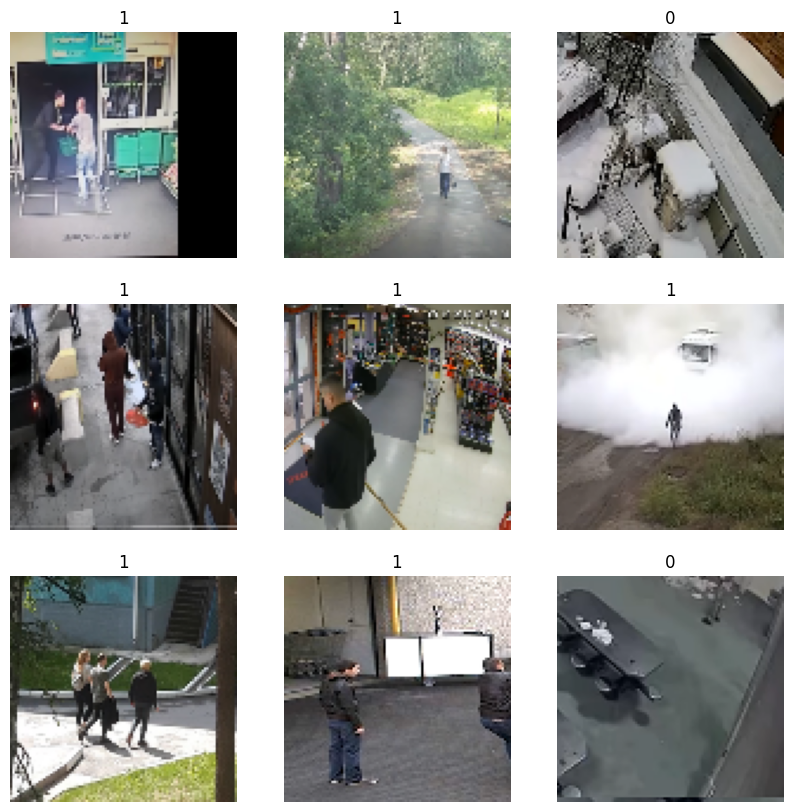

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch.reshape(-1).astype("uint8"))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Summary

* **Using transfer learning for Mask Detection**: In this lab, we learned how we can use transfer learning to detect if a person is wearing mask or not. When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain.



# Model conversion

## Original float model

In [62]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # dynamic range quantization. size reduction but computing is done in fp32
tflite_model = converter.convert()

import pathlib
tflite_model_file = pathlib.Path('model/model-float32.tflite')
tflite_model_file.write_bytes(tflite_model)



W0000 00:00:1731369020.982616 4657986 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731369020.982948 4657986 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-11 17:50:20.985532: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6z4rfliv
2024-11-11 17:50:20.998944: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-11 17:50:20.998961: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6z4rfliv
2024-11-11 17:50:21.087866: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-11 17:50:21.379588: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmp6z4rfliv
2024-11-11 17:50:21.487964: I tensorflow/cc/saved_model/loader.cc:

550632

## Quantized model

In [53]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  

def representative_data_get():
    for input_value, _ in val_dataset.take(100):
        yield [input_value]

converter.representative_dataset = representative_data_get
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model_quant = converter.convert()
tflite_model_quant_file = pathlib.Path('model/model-int8.tflite')
tflite_model_quant_file.write_bytes(tflite_model_quant)

/Users/h488y928/env-python3.10/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1731368686.494379 4657986 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1731368686.494401 4657986 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-11 17:44:46.494632: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpey6m2v4y
2024-11-11 17:44:46.507820: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-11 17:44:46.507838: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/2_/kskwshj16hqb0586p6cydg4h0000gq/T/tmpey6m2v4y
2024-11-11 17:44:46.597611: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-11 17:44:46.888460: I tensorflow

625440

## Inference

In [54]:
image_batch, label_batch = val_dataset.as_numpy_iterator().next()
img = image_batch[0,:,:,:]
print (img.flatten())

# Write a C source file of the image for debugging purposes (to check if the model output is correct)
with open('src/img.h', 'w') as f:
    f.write('#ifndef IMG_TEST_DATA\n')
    f.write('#define IMG_TEST_DATA\n')
    f.write('const float img_data[] = {')
    for i in range(0, len(img.flatten())):
        f.write(str(img.flatten()[i]))
        if i < len(img.flatten()) - 1:
            f.write(',')    
    f.write('};\n')
    f.write('#endif\n')



2024-11-11 17:44:52.100228: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.109814: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.236271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.247628: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.264022: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.330134: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.473114: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.591769: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:44:52.598958: W tensorflow/core/lib/png/png_io.cc:89] PNG 

[181.69444 183.69444 183.83333 ...  85.66666  83.66666  81.80555]


2024-11-11 17:44:54.322879: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, np.expand_dims(img, axis=0))
interpreter.invoke()
output = interpreter.get_tensor(output_index)
print(output.flatten())
if output.flatten()[0] >= 0.5:
    print("Person")
else:
    print("No person")

[0.99609375]
Person


(96, 96, 3)
[181 183 183]
[181.69444 183.69444 183.83333]


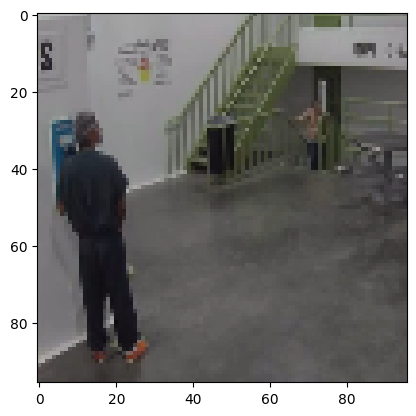

In [64]:
plt.imshow(img.astype("uint8"))
print(img.astype("uint8").shape)
print(img.astype("uint8").flatten()[:3])
print(img.astype("float32").flatten()[:3])

In [65]:
from tqdm import tqdm

def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []

    for test_image, test_label in tqdm(val_dataset):
        for i in range(len(test_label)):
            interpreter.set_tensor(input_index, np.expand_dims(test_image[i], axis=0))
            interpreter.invoke()
            prediction_digits.append(interpreter.get_tensor(output_index))
            test_labels.append(test_label[i])
    prediction_digits = np.array(prediction_digits).flatten().reshape(-1, 1)
    print(prediction_digits[:10])
    test_labels = np.array(test_labels)
    print(test_labels[:10])
    prediction_digits = np.where(prediction_digits < 0.5, 0, 1)
    print(prediction_digits[:10])

    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Float model accuracy = ', test_accuracy)

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()
test_accuracy = evaluate_model(interpreter)

print('Quantized model accuracy = ', test_accuracy)


  0%|          | 0/5 [00:00<?, ?it/s]2024-11-11 17:55:16.697972: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:16.703708: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:16.816678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:16.818216: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:16.835255: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:16.903870: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:17.049746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:17.167936: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:17.177701: W tenso

[[0.03851444]
 [0.99745905]
 [0.9908572 ]
 [0.152895  ]
 [0.36162317]
 [0.9893045 ]
 [0.8384061 ]
 [0.85905164]
 [0.02004129]
 [0.00658896]]
[[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]
[[0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]]
Float model accuracy =  0.975


  0%|          | 0/5 [00:00<?, ?it/s]2024-11-11 17:55:19.184462: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.191009: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.307843: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.311172: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.326648: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.395395: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.529763: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.655180: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2024-11-11 17:55:19.664209: W tenso

[[0.015625  ]
 [0.0859375 ]
 [0.37109375]
 [0.99609375]
 [0.9140625 ]
 [0.9296875 ]
 [0.2421875 ]
 [0.23046875]
 [0.99609375]
 [0.03515625]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]
[[0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]]
Quantized model accuracy =  0.9375


## Generate model CC file

In [66]:
model_file = 'model-int8'
!xxd -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" | sed "s/model_model_int8_tflite/gmodel/g"> src/model.cc
# !xxd -n gmodel -i model/{model_file}.tflite | sed "s/unsigned/const unsigned/g" > src/model.cc